In [235]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.stats import skew, kurtosis
import seaborn as sns
sns.set()
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from matplotlib.backends import backend_pdf
from matplotlib.colors import LinearSegmentedColormap
from sklearn.tree import DecisionTreeClassifier, plot_tree

FS = 64

LABELS = {'Poor': -1, 'Medium': 0, 'Good': 1}
COLORS = ['red', 'blue', 'green']
annotators = ['Tomek', 'Karolina', 'Janek']

LOW = np.array((226, 67, 65)) / 255
MEDIUM = np.array((161, 163, 241)) / 255
HIGH = np.array((57, 248, 74)) / 255

COLORMAP = LinearSegmentedColormap.from_list(
    "Custom", [LOW, MEDIUM, HIGH], N=1000
)

In [236]:
tomek_results = pd.read_csv('../data/Tomek/results.csv', index_col=0)
karo_results = pd.read_csv('../data/Karo/results.csv', index_col=0)
janek_results = pd.read_csv('../data/Janek/results.csv', index_col=0)

results = pd.concat([tomek_results, karo_results, janek_results]).reset_index(drop=True)
results['rating'] = results['label'].apply(lambda label: LABELS[label])

tomek_signals = [pd.read_csv(f"../data/Tomek/samples/{sample_num}.csv", index_col=0).bvp.values for sample_num in range(len(tomek_results))]
karo_signals = [pd.read_csv(f"../data/Karo/samples/{sample_num}.csv", index_col=0).bvp.values for sample_num in range(len(karo_results))]
janek_signals = [pd.read_csv(f"../data/Janek/samples/{sample_num}.csv", index_col=0).bvp.values for sample_num in range(len(janek_results))]

signals = [*tomek_signals, *karo_signals, *janek_signals]

In [237]:
tomek_results = pd.read_csv('../data/Tomek/results.csv', index_col=0)
tomek_results['rating'] = tomek_results['label'].apply(lambda label: LABELS[label])
tomek_signals = [pd.read_csv(f"../data/Tomek/samples/{sample_num}.csv", index_col=0).bvp.values for sample_num in range(len(tomek_results))]

In [238]:
example_signals = [pd.read_csv(f"../data/examples/{sample_num}.csv", index_col=0).bvp.values for sample_num in range(40)]

In [239]:
def save_figs_to_pdf(*figs, path):
    pdf = backend_pdf.PdfPages(path)
    for fig in figs:
        pdf.savefig(fig)
    pdf.close()
    

def entropy(data):
    squared_data = data ** 2
    return -(squared_data * np.log(squared_data)).sum() / len(squared_data)


def find_zero_cross(data):      
    zero_cross = np.sign(np.diff(np.sign(data)))
    positive = np.where(zero_cross == 1)[0]  # from minut to plus
    negative = np.where(zero_cross == -1)[0]  # from plus to minus
    return positive, negative


def get_zero_cross_features(data):
    n_samples = len(data)
    new_n_samples = n_samples * 100
    t = np.linspace(0, n_samples/FS, n_samples, endpoint=False)
    interp_fn = interpolate.interp1d(t, data, fill_value="extrapolate")
    t_new = np.linspace(0, n_samples/FS, new_n_samples, endpoint=False)
    data_interp = interp_fn(t_new)
    positive_zc, negative_zc = find_zero_cross(data_interp)
    positive_zc_times = t_new[positive_zc]
    negative_zc_times = t_new[negative_zc]    
    
    positive_zc_intervals = np.diff(positive_zc_times)
    negative_zc_intervals = np.diff(negative_zc_times)
    
    zero_cross_features = {
        'pos_zc_int_mean': positive_zc_intervals.mean(),
        'pos_zc_int_std': positive_zc_intervals.std(),
        'neg_zc_int_mean': negative_zc_intervals.mean(),
        'neg_zc_int_std': negative_zc_intervals.std(),
        
    }
    return zero_cross_features


def get_quality_features(data):
    data_standardized = (data - data.mean()) / data.std()
    quality_features = {
        'std': np.std(data),
        'skew': skew(data_standardized),
        'kurtosis': kurtosis(data_standardized),
        'entropy': entropy(data_standardized),
        **get_zero_cross_features(data_standardized)
    }
    return quality_features


def get_windows(start, max_len, win_len, step):
    end = start + win_len
    windows = []
    while end < max_len:
        windows.append((start, end))
        start += step
        end += step
    windows.append(np.array([start, max_len]))
    return np.array(windows)


def train_model(features_df, ModelClass=RandomForestClassifier, model_params={}):
    X = features_df.drop('label', axis=1).values
    y = features_df['label'].values
    
    model = ModelClass(**model_params)
    model.fit(X, y)
    return model


def rate_signal(signal, signal_quality_model, win_len=5, step=1, plot=True):
    signal_df = pd.DataFrame(data=signal, index=np.linspace(0, len(signal)/FS, len(signal), endpoint=False), columns=['data'])
    windows = get_windows(0, signal_df.index[-1], win_len, step)
    signal_slices = [signal_df.loc[start:end].values.flatten() for start, end in windows]
    signal_features = [{
        **get_quality_features(data),
        'start': start,
        'end': end
    } for data, (start, end) in zip(signal_slices, windows)]
    signal_features_df = pd.DataFrame(signal_features)#.dropna()
    imputer = SimpleImputer()
    features_array = imputer.fit_transform(signal_features_df.drop(['start', 'end'], axis=1).values)
    signal_slices_labels = signal_quality_model.predict(features_array)
    signal_features_df['label'] = signal_slices_labels
    if plot:
        sig_range = signal.max() - signal.min()
        margin = 0.05 * sig_range
        lower_bound, upper_bound = signal.min() - margin, signal.max() + margin

        fig, ax = plt.subplots(figsize=(24, 5))
        ax.plot(signal_df.index, signal_df.data, color='black', lw=3)
        for label, (start, end) in zip(signal_slices_labels, windows):
            ax.fill_between([start, end], lower_bound, upper_bound, alpha=0.05, color=COLORS[label+1])

        ax.set_ylim([lower_bound, upper_bound])
        ax.set_xlim([0, 100])
        
        return fig
    return signal_features_df


def plot_feature_importance(feat_names: list, feat_importances: list, n_best: int = 10, normalize: bool = True, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(16, 8))
    sorted_importances = sorted(feat_importances, reverse=False)
    sorted_feat_names = [
        feat_name
        for _, feat_name in sorted(zip(feat_importances, feat_names), reverse=False)
    ]
    best_feat_names = np.array(sorted_feat_names[-n_best:])
    normalize_factor = sum(feat_importances) if normalize else 1
    best_feat_importanes = np.array(sorted_importances[-n_best:]) / normalize_factor
    ax.barh(best_feat_names, best_feat_importanes)
    ax.set_title("Feature importance", fontsize=22)

In [240]:
features_df = pd.DataFrame([get_quality_features(signal) for signal in signals])#.dropna()
features_df['label'] = results['rating']
features_df = features_df.dropna()

/tmp/ipykernel_99605/2310597258.py:35: RuntimeWarning: Mean of empty slice.
  'pos_zc_int_mean': positive_zc_intervals.mean(),
/home/shate/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/shate/.local/lib/python3.8/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/shate/.local/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/shate/.local/lib/python3.8/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_99605/2310597258.py:37: RuntimeWarning: Mean of empty slice.
  'neg_zc_int_mean': negative_zc_intervals.mean(),


In [242]:
signal_quality_model = train_model(features_df, RandomForestClassifier)

/tmp/ipykernel_99605/2310597258.py:35: RuntimeWarning: Mean of empty slice.
  'pos_zc_int_mean': positive_zc_intervals.mean(),
/home/shate/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/shate/.local/lib/python3.8/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/shate/.local/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/shate/.local/lib/python3.8/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_99605/2310597258.py:37: RuntimeWarning: Mean of empty slice.
  'neg_zc_int_mean': negative_zc_intervals.mean(),
/tmp/ipykerne

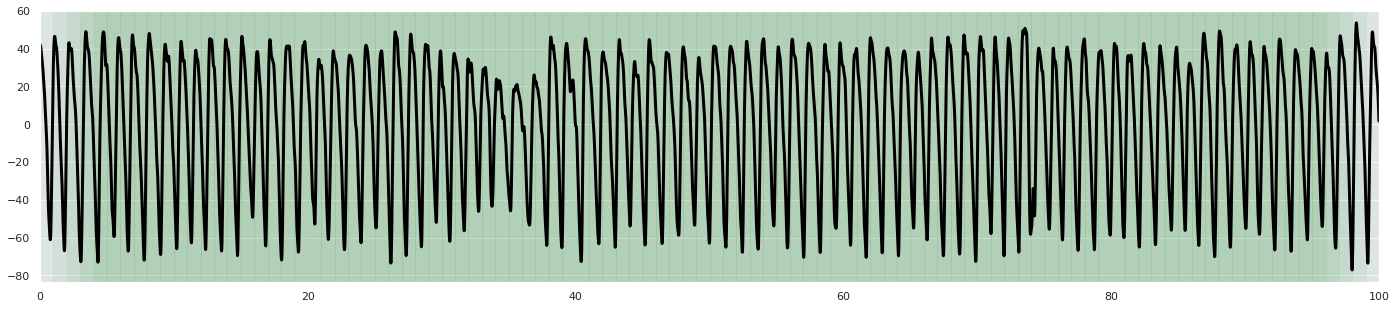

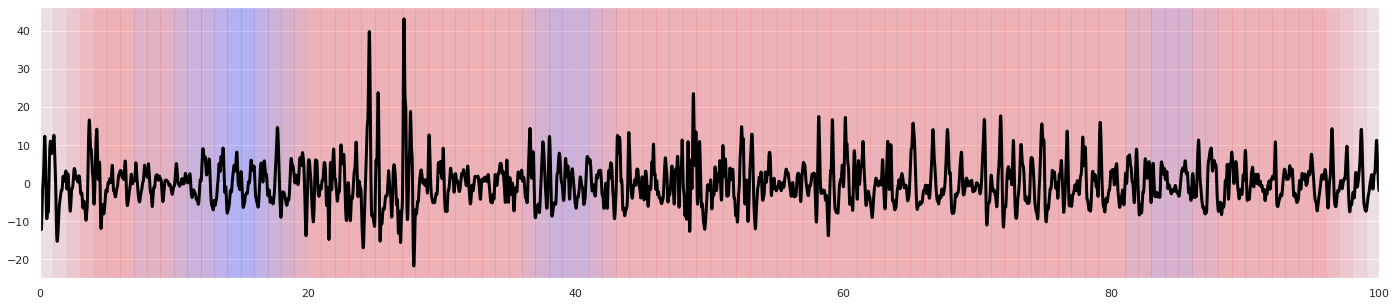

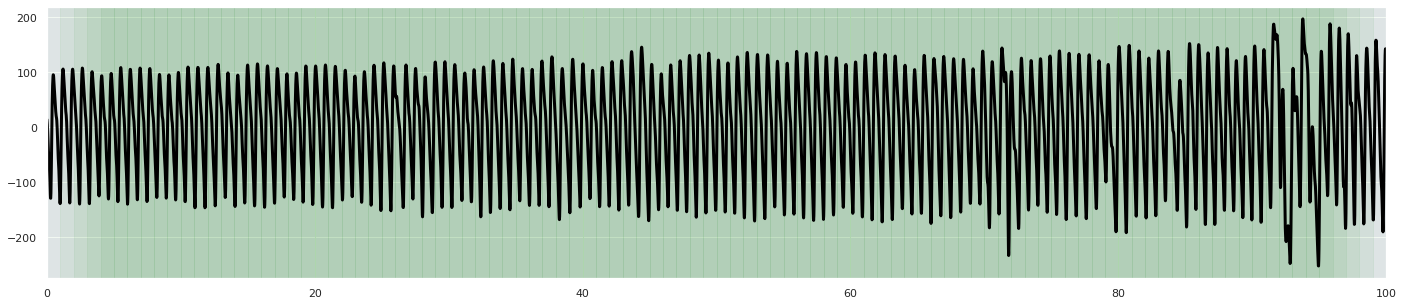

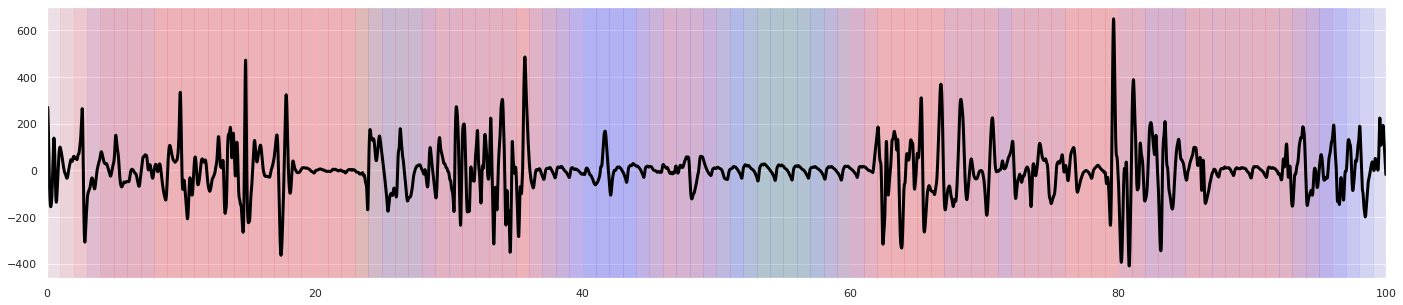

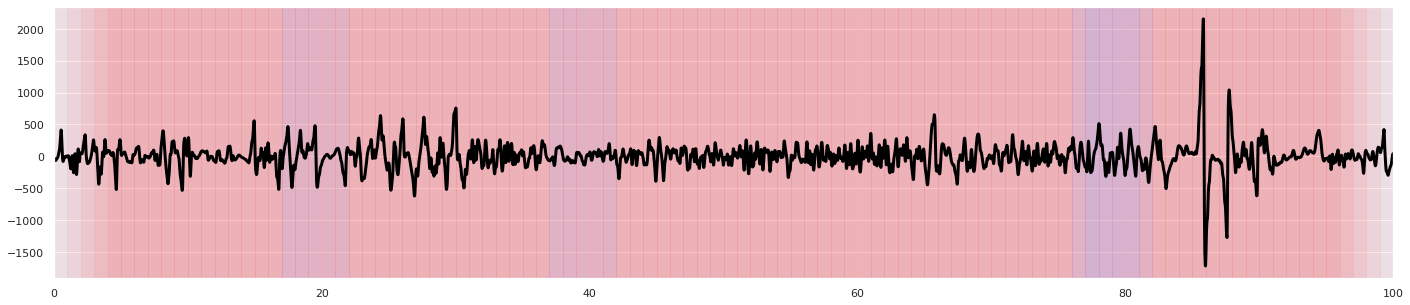

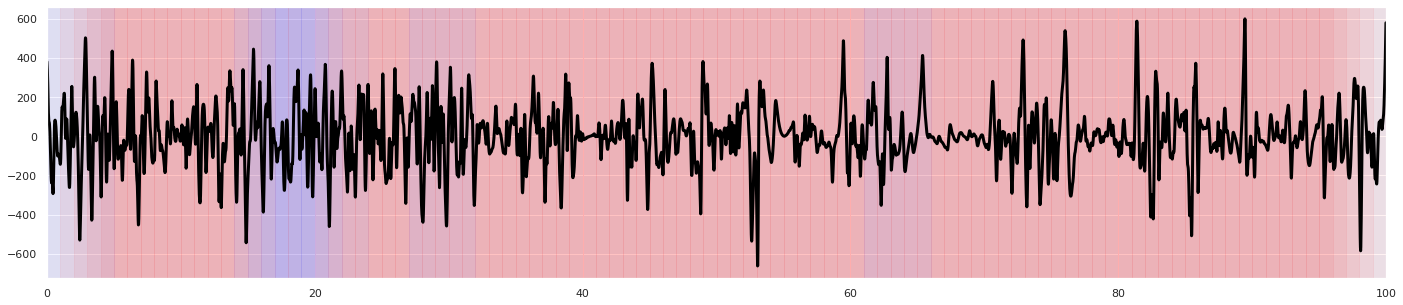

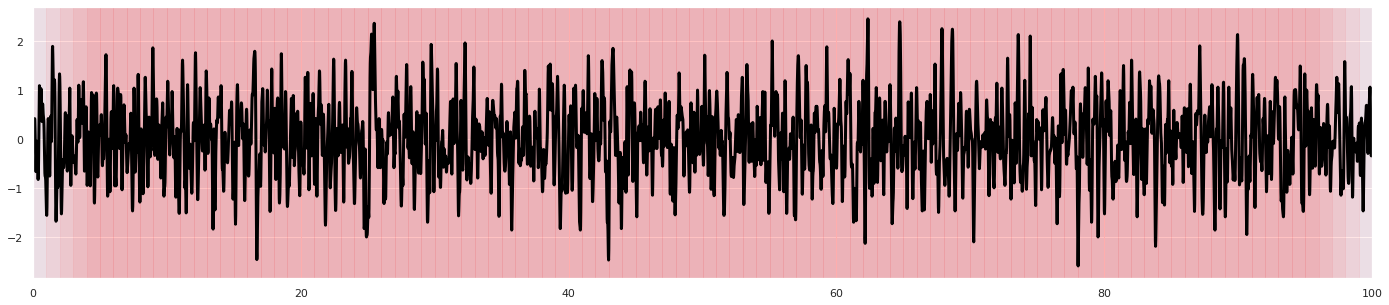

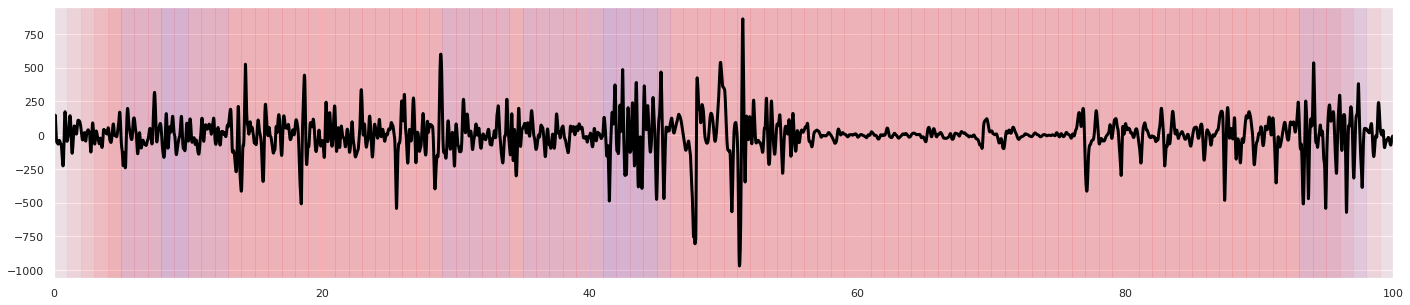

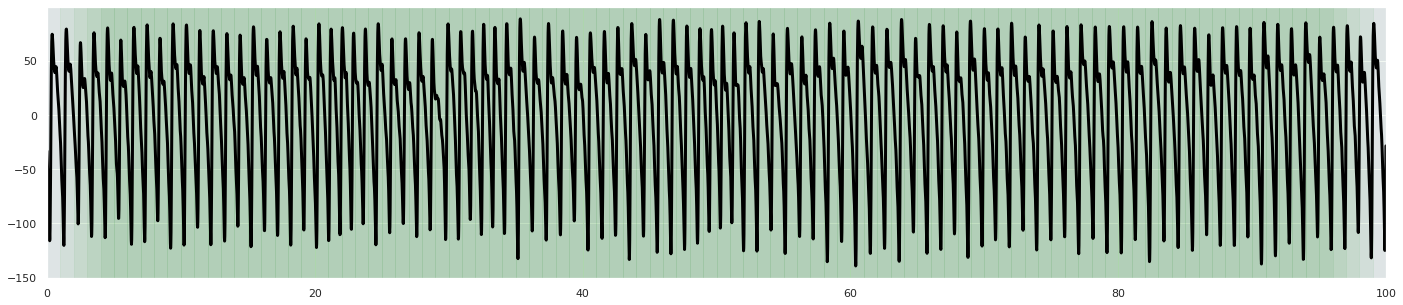

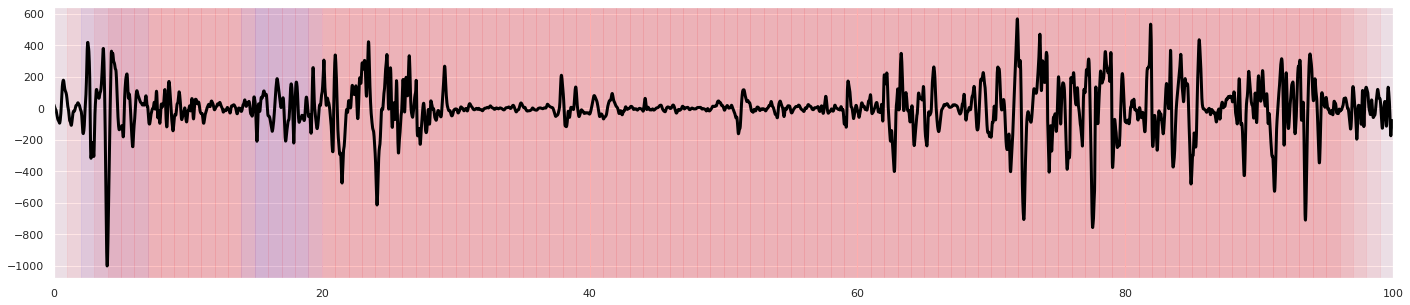

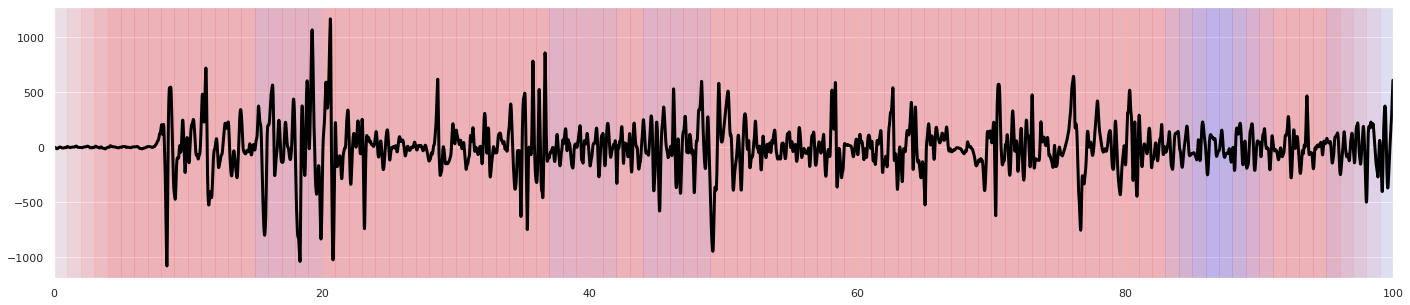

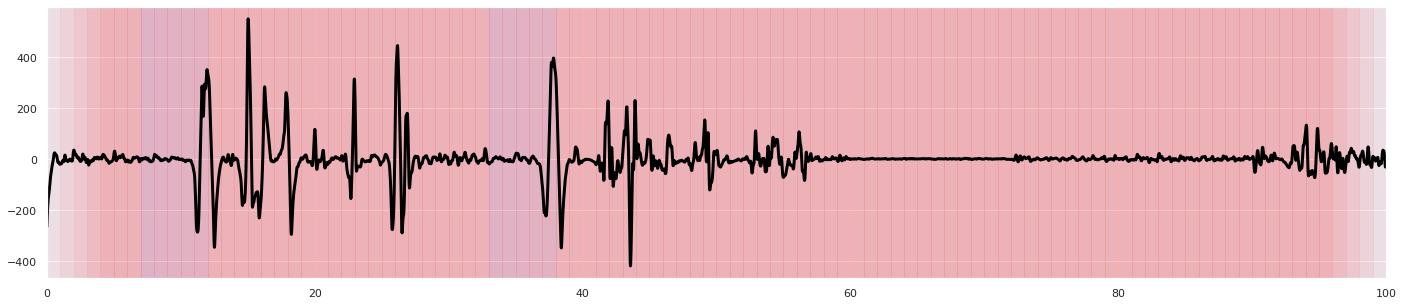

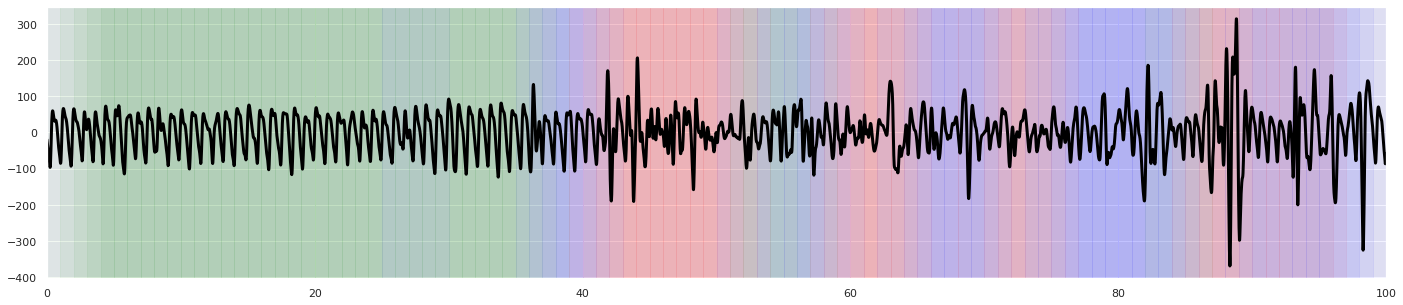

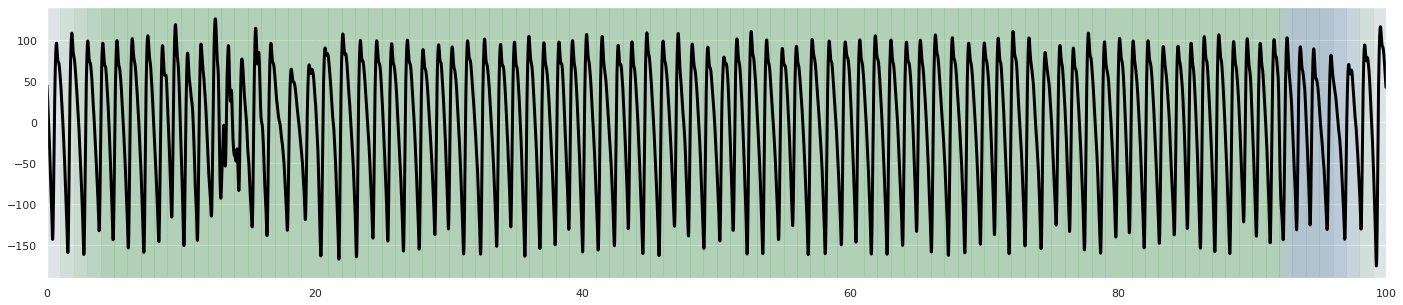

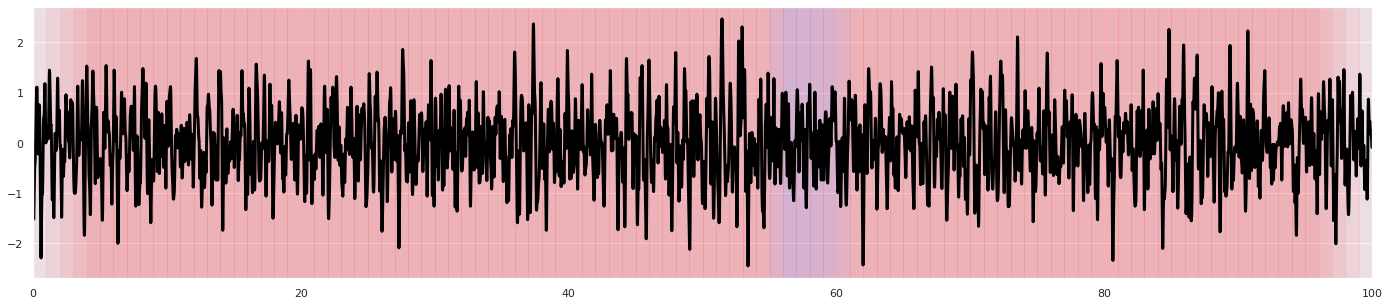

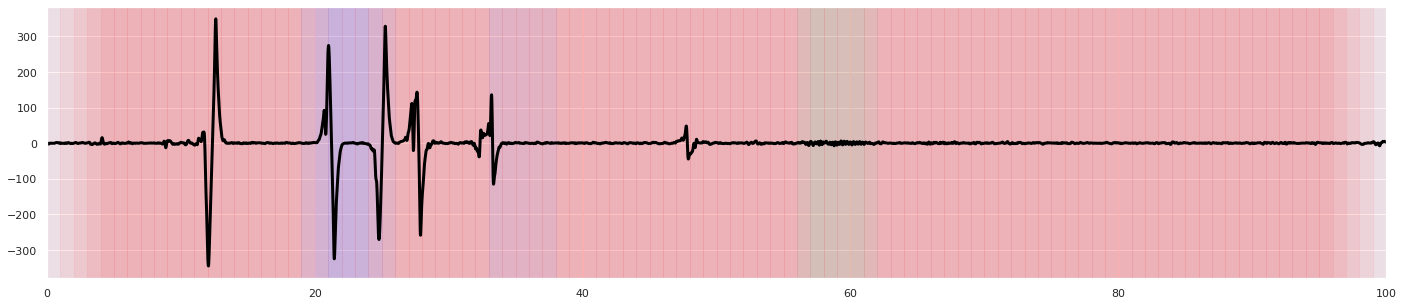

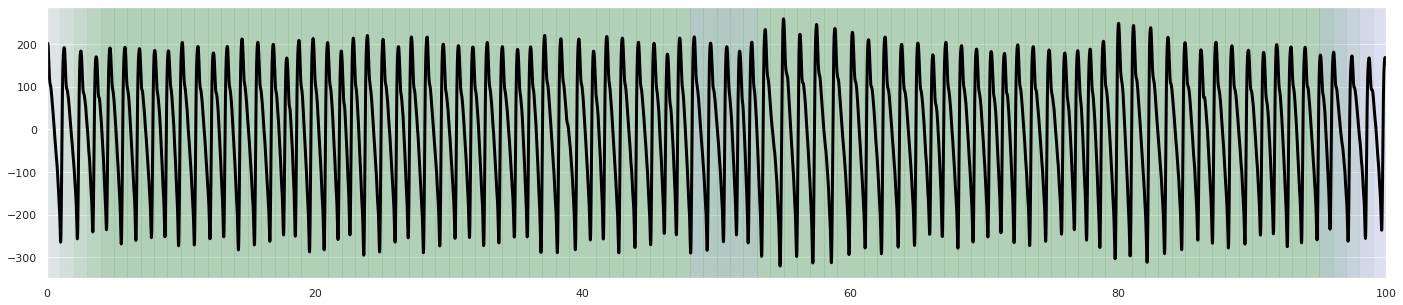

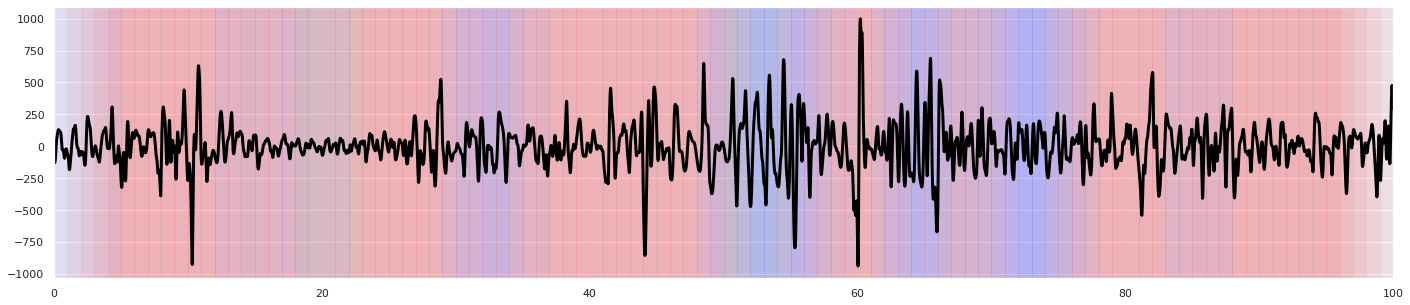

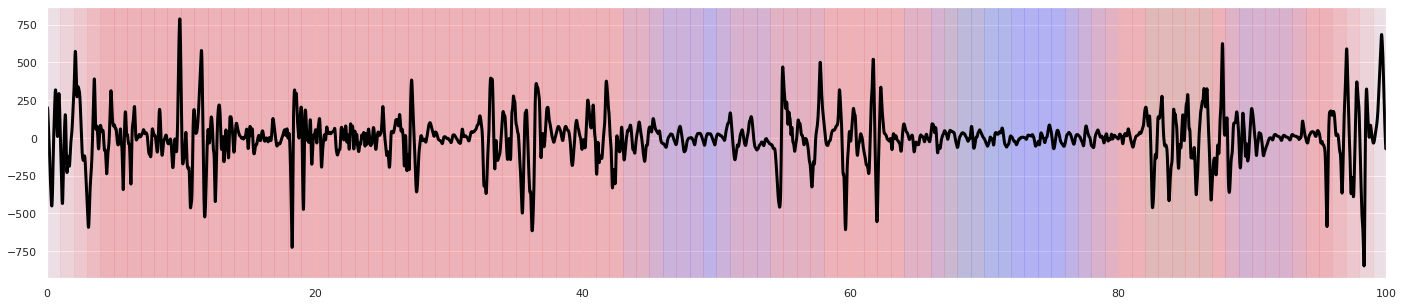

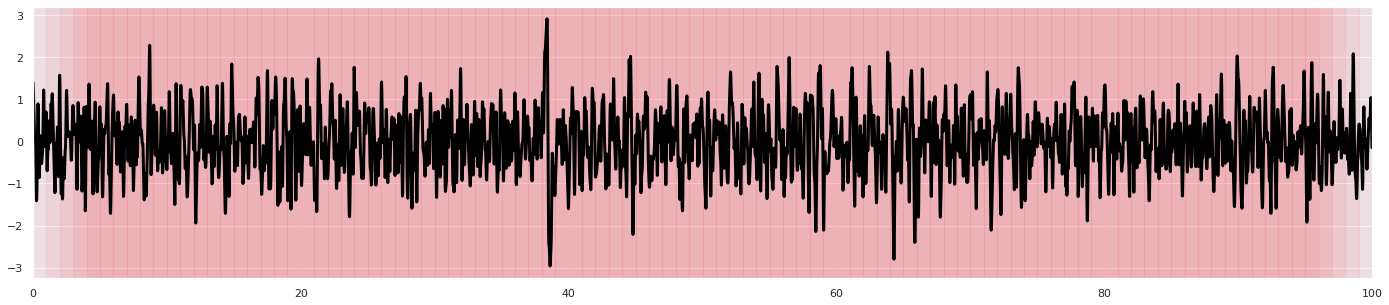

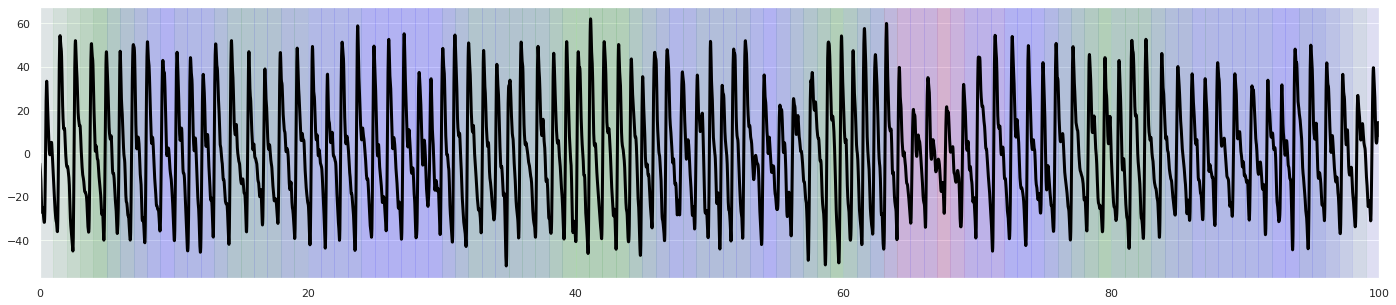

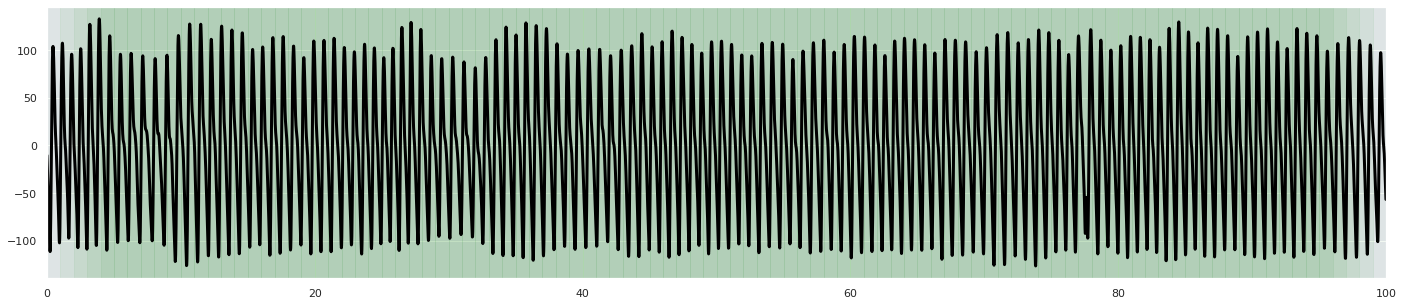

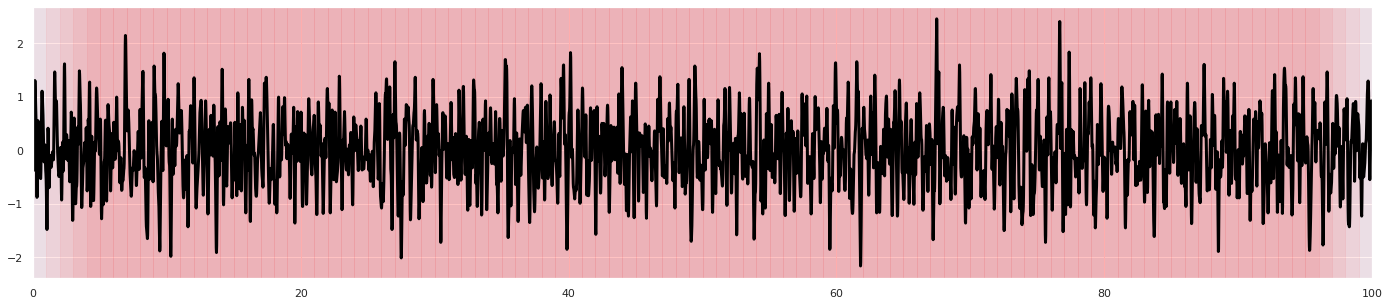

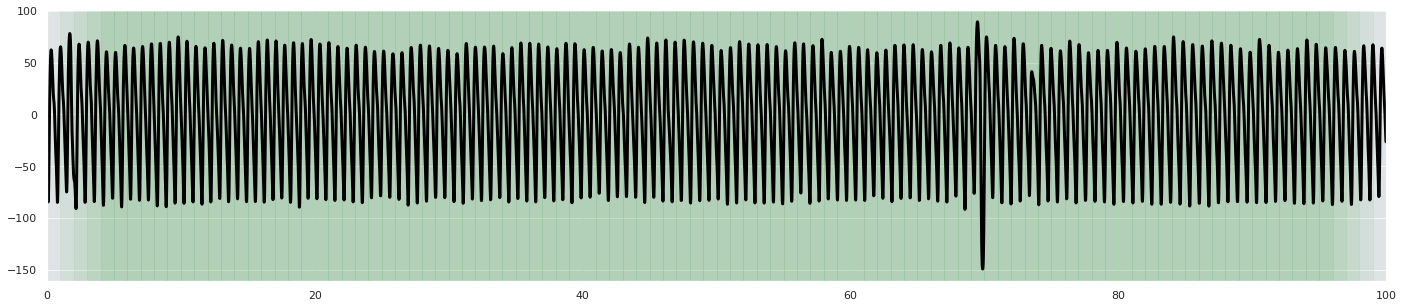

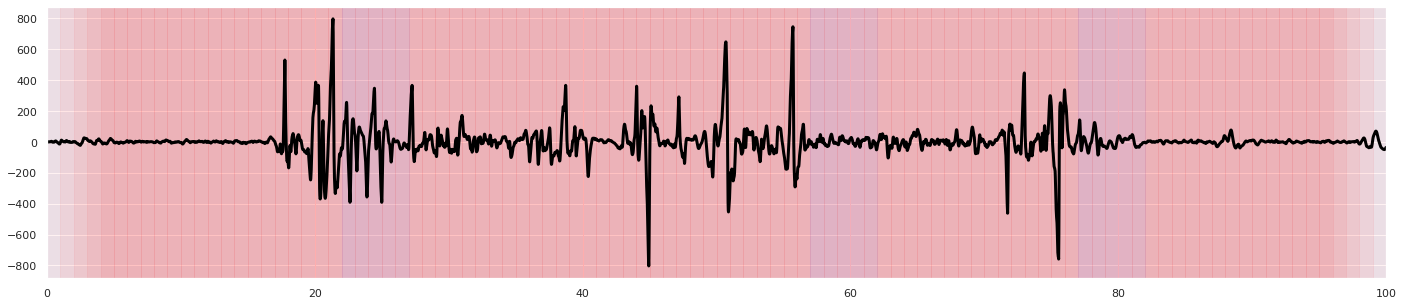

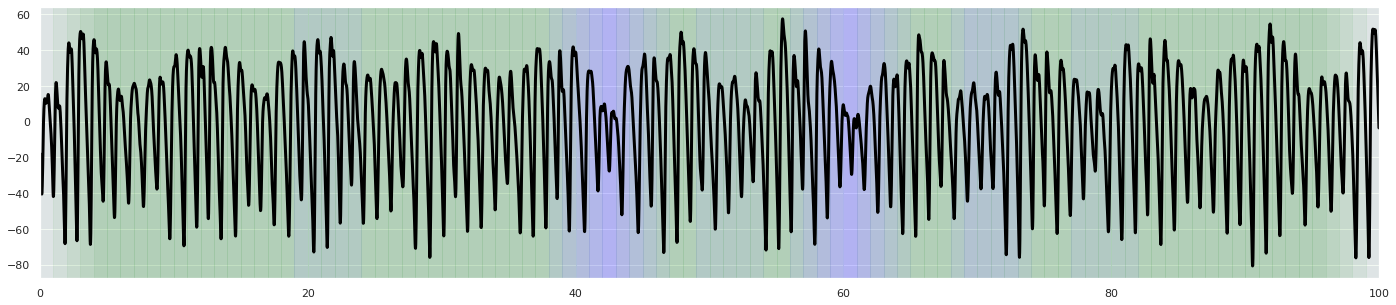

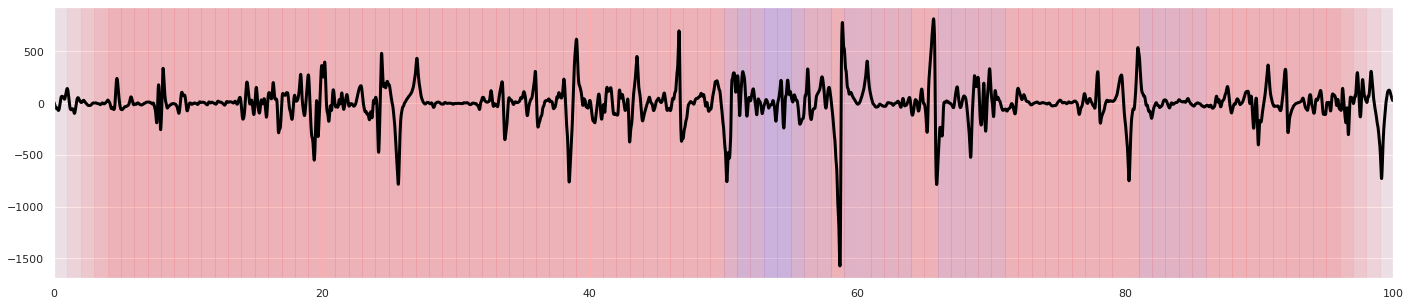

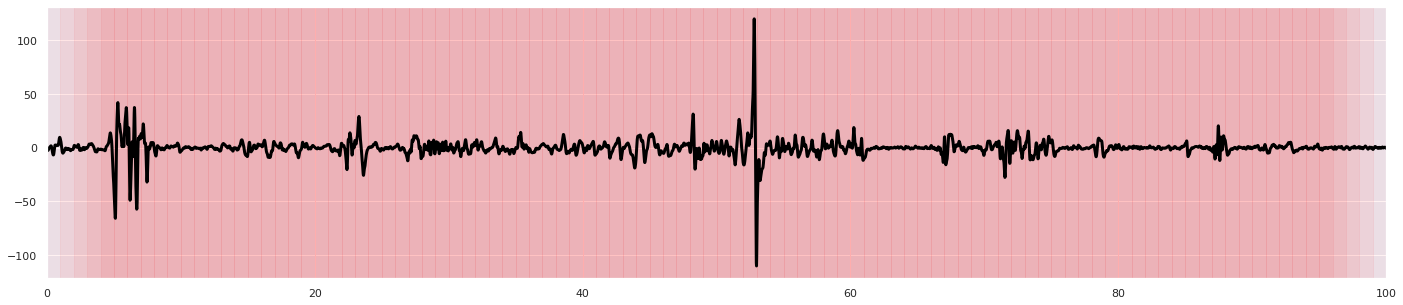

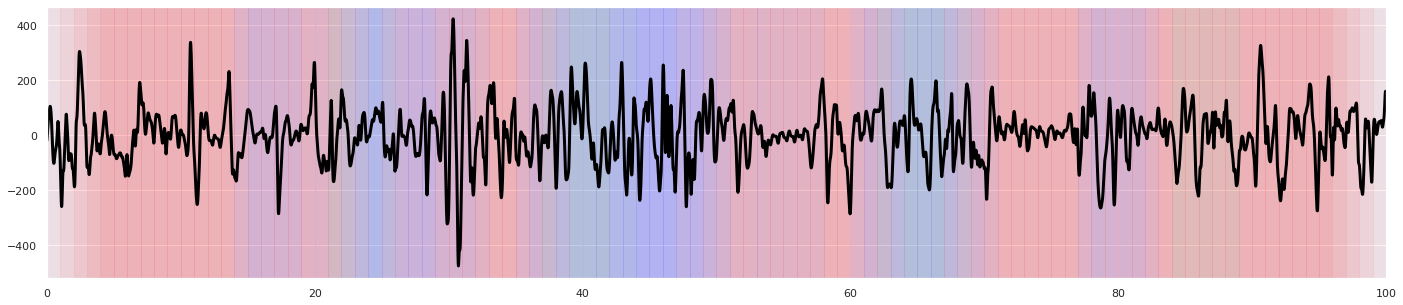

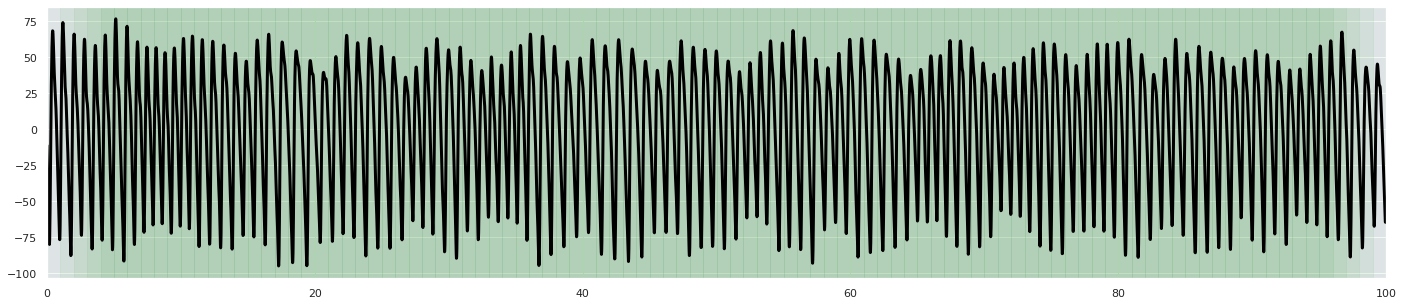

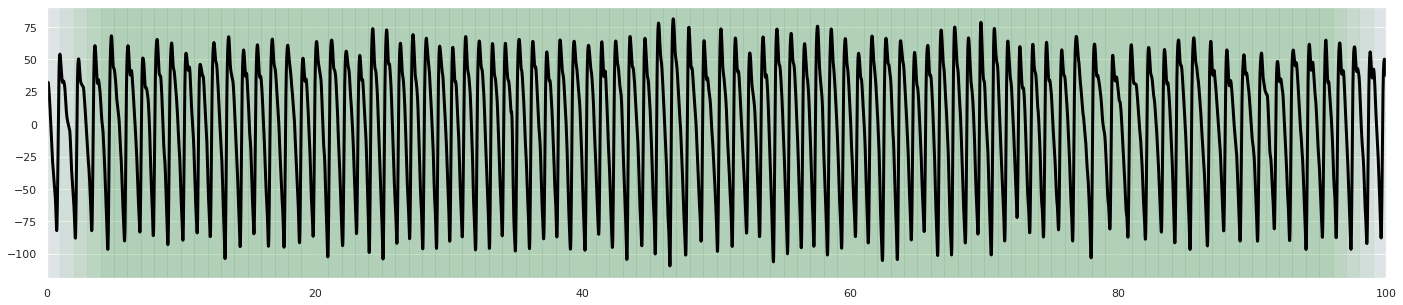

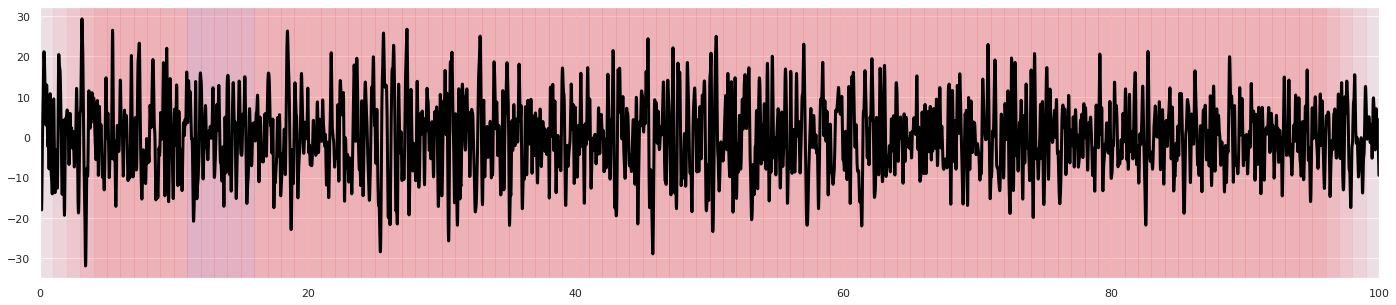

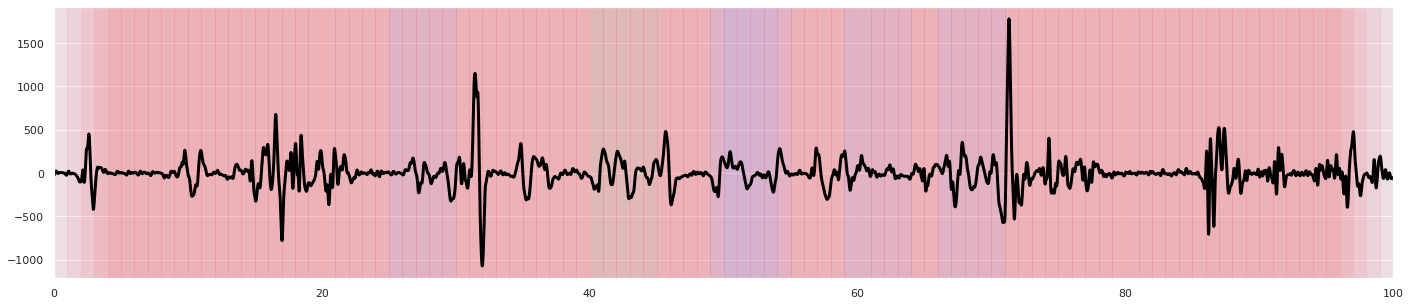

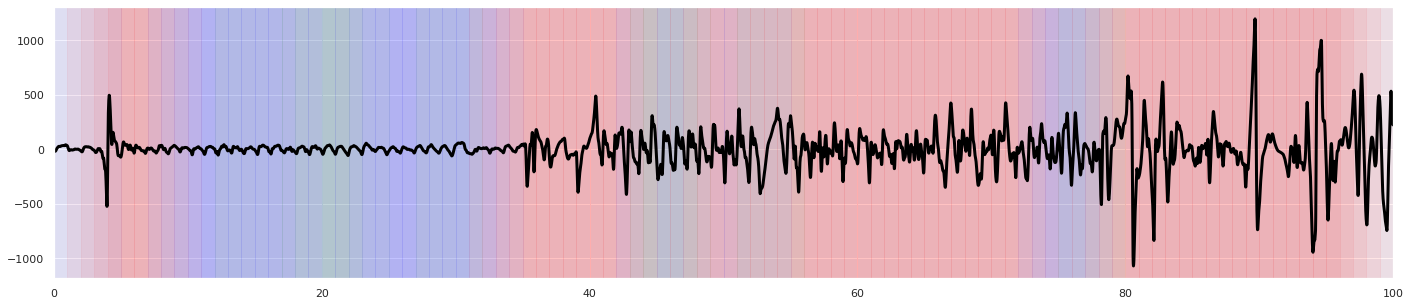

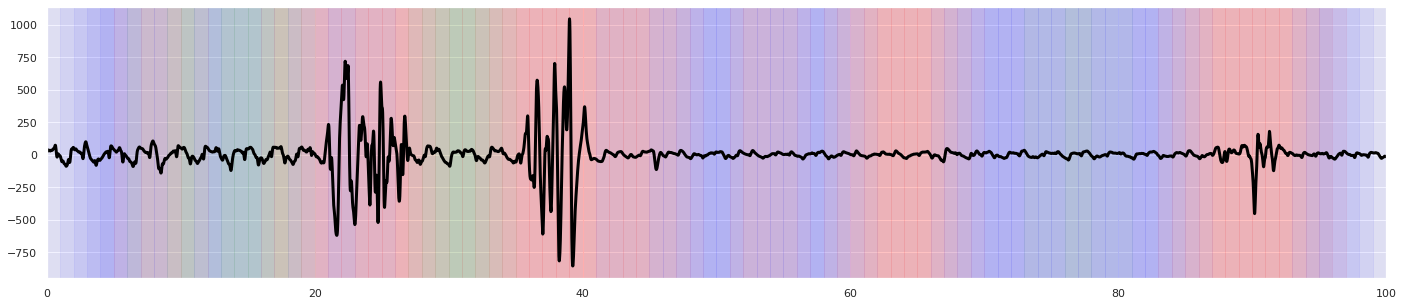

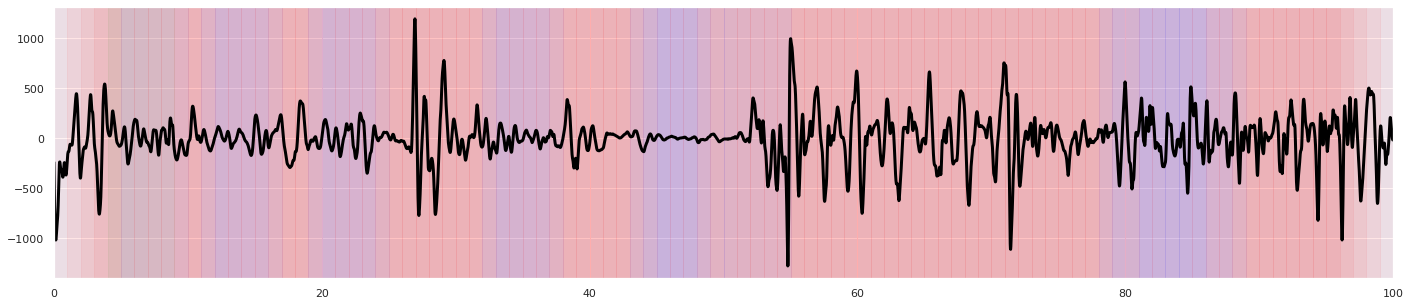

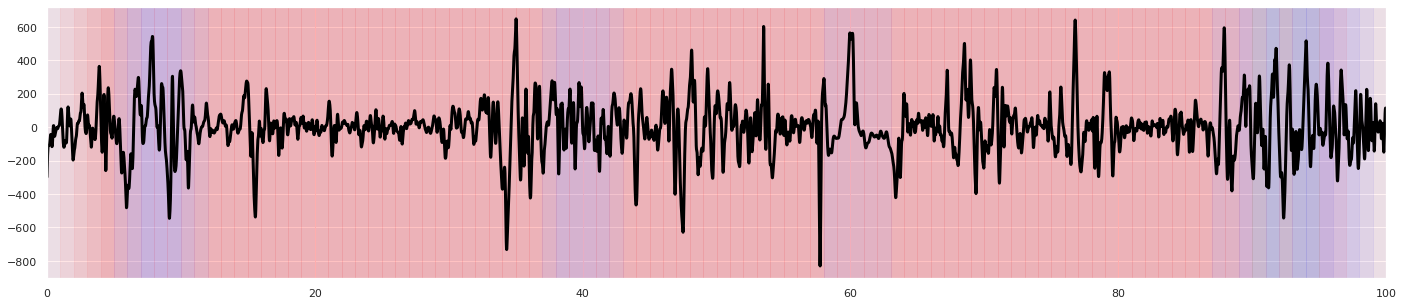

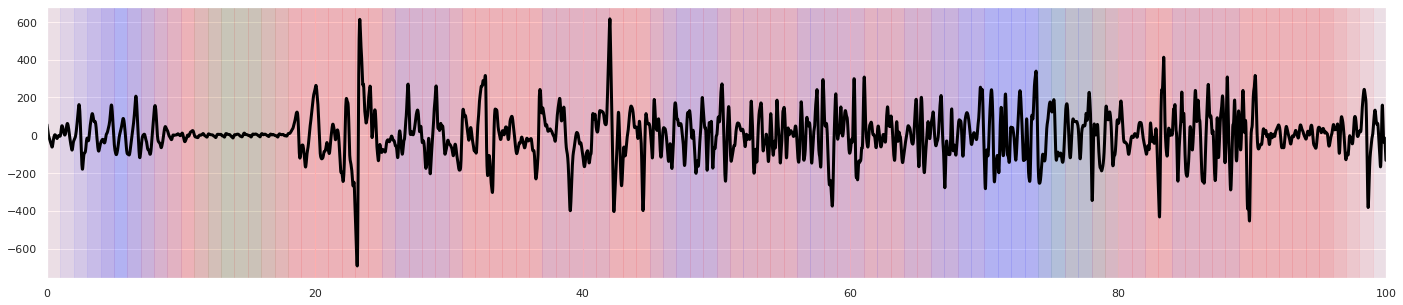

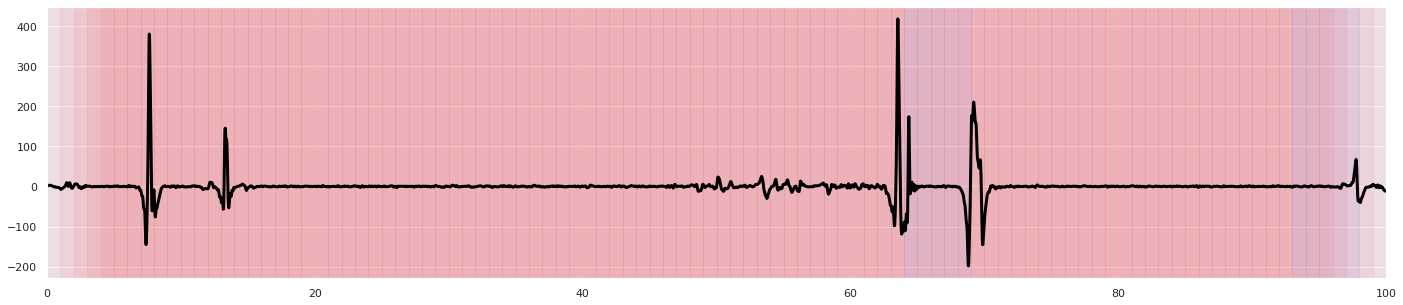

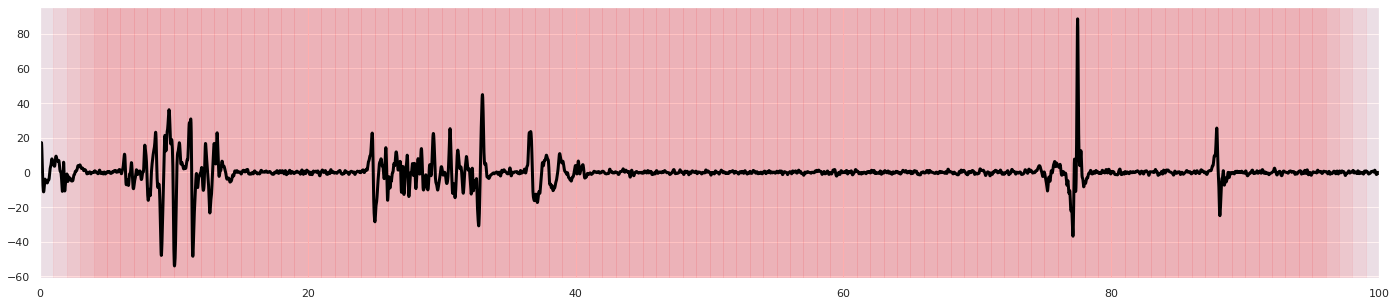

In [52]:
figs = []

for signal in example_signals:
    fig = rate_signal(signal, signal_qality_model, plot=True)
    figs.append(fig)
    
save_figs_to_pdf(*figs, path='examples_labeled_by_quality_model.pdf')

---
# **Signal quality model evaluation**

In [54]:
train_df, test_df = train_test_split(features_df.dropna(), test_size=0.2)

X_train = train_df.drop('label', axis=1).values
X_test = test_df.drop('label', axis=1).values

y_train = train_df['label'].values
y_test = test_df['label'].values

model = RandomForestClassifier()
model = DecisionTreeClassifier(max_depth=2)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [55]:
acc = accuracy_score(y_test, y_pred)
fscore = f1_score(y_test, y_pred, average='macro')

print(f"Metrics:\n accuracy = {acc:.2f}\n fscore_macro = {fscore:.2f}")

Metrics:
 accuracy = 0.86
 fscore_macro = 0.64


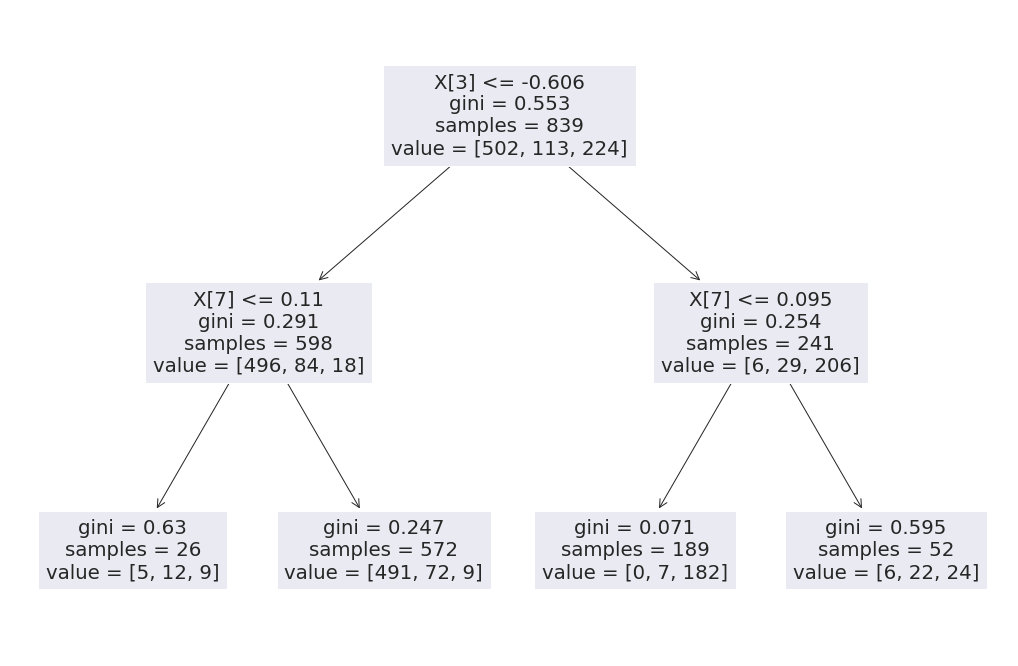

In [56]:
fig, ax = plt.subplots(figsize=(18, 12))
rules = plot_tree(model, ax=ax)

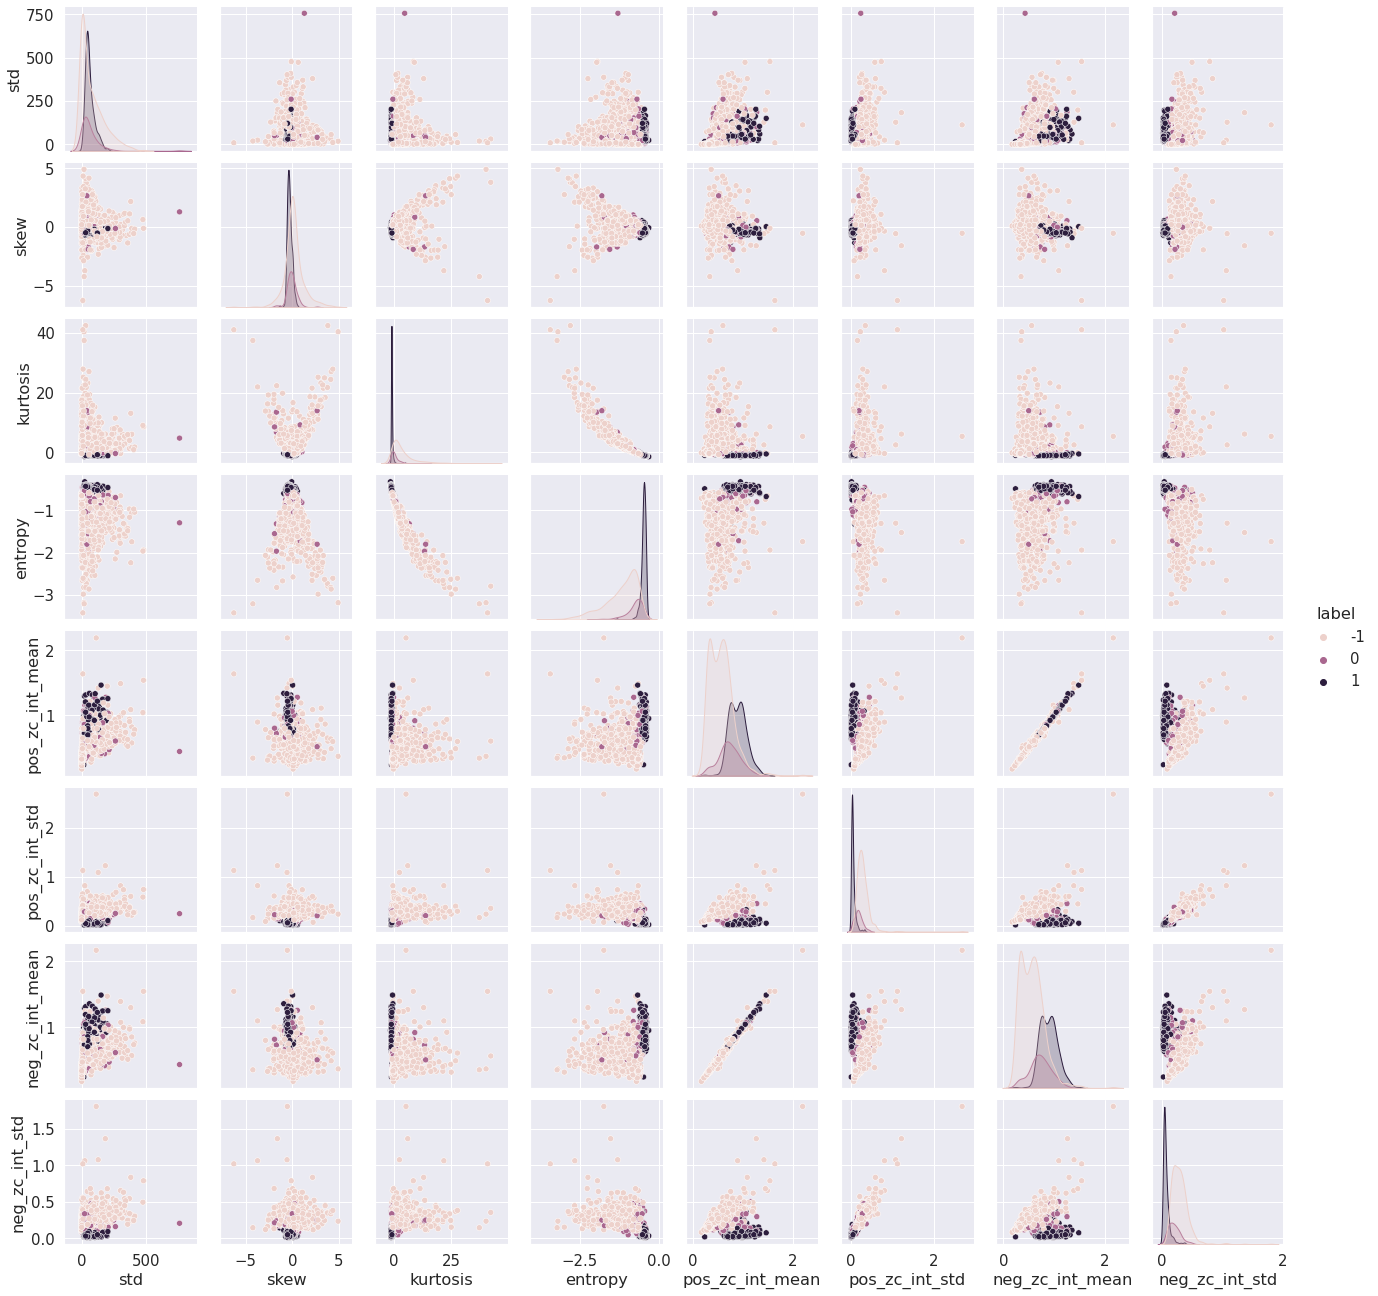

In [62]:
sns.set(font_scale=1.35)
sns.pairplot(features_df, hue='label', height=2.3)

In [58]:
features_df.columns.values

array(['std', 'skew', 'kurtosis', 'entropy', 'pos_zc_int_mean',
       'pos_zc_int_std', 'neg_zc_int_mean', 'neg_zc_int_std', 'label'],
      dtype=object)

In [27]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=[-1, 0, 1])
conf_matrix = pd.DataFrame(conf_matrix, index=LABELS.keys(), columns=LABELS.keys())

<AxesSubplot:>

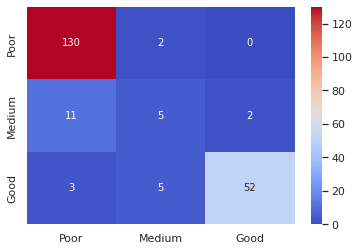

In [28]:
sns.heatmap(conf_matrix, cmap='coolwarm', annot=True, fmt='g')

/home/shate/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='label', ylabel='count'>

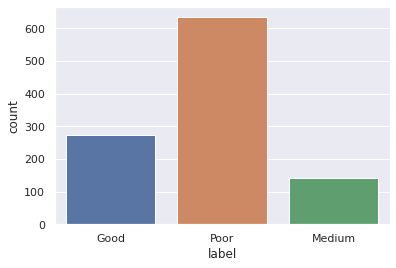

In [29]:
sns.countplot(results['label'])

<AxesSubplot:xlabel='neg_zc_int_mean', ylabel='pos_zc_int_mean'>

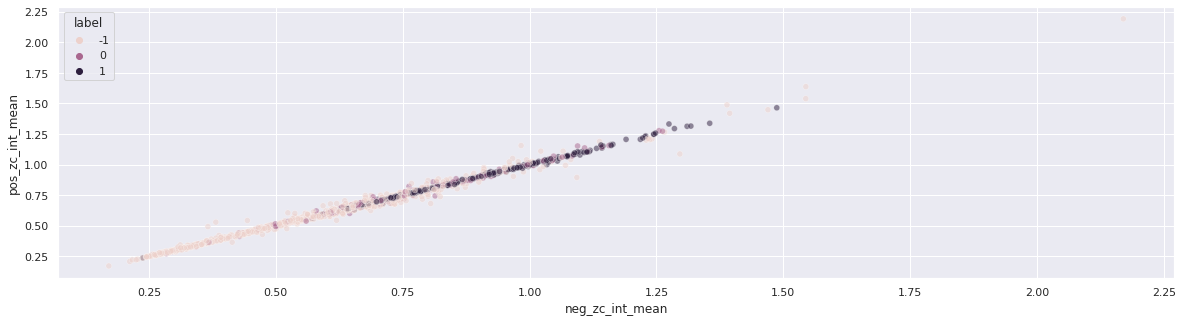

In [703]:
plt.figure(figsize=(20, 5))
sns.scatterplot(data=features_df, x='neg_zc_int_mean', y='pos_zc_int_mean', hue='label', alpha=0.5)

In [ ]:
IF (pos_zc_int_mean IS 1) AND (neg_zc_int_mean IS 1) THEN (quality IS low)
IF (pos_zc_int_mean IS 2) AND (neg_zc_int_mean IS 2) THEN (quality IS low)

* `entropy`: **od -3.5 do 0** -> od **-0.6 do 0** sa dobre wyniki
* `kurtosis` **od -5 do 45** -> od **-5 do 0** sa dobre wyniki
* `std` **od 0 do 500** -> wartosci **< 1** to zle wyniki
* `neg_zc_int_std` **od 0 do 2** -> wartosci **od 0 do 0.1** to dobre wyniki, **od 0.1 do 0.3** to srednie wyniki, a **od 0.3 w gore** to zle wyniki
* `skew` (**od -5 do 5**) i `pos_zc_int_mean` (**od 0.2 do 1.5**)  -> wartosci `skew` **od -1 do 1** i wartosci `pos_zc_int_mean` **od 0.6 do 1.5** to dobre wyniki
* signal_features_df

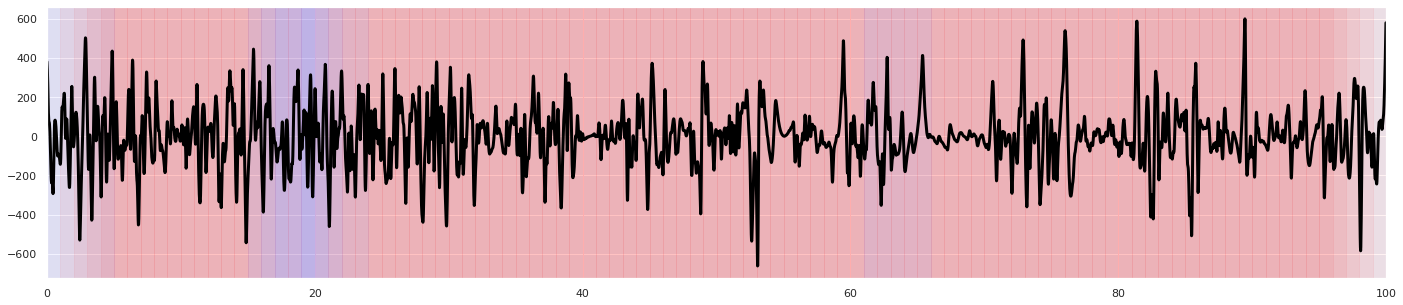

In [253]:
fig = rate_signal(signal, signal_quality_model)

In [693]:
def define_target_fuzzy_sets():
    # min_val, max_val, mean_val, std = arr.min(), arr.max(), arr.mean(), arr.std()
    FS_1 = FuzzySet(function=InvSigmoid_MF(c=-0.7, a=15), term="low")
    FS_2 = FuzzySet(function=Gaussian_MF(mu=0, sigma=0.3), term="medium")
    FS_3 = FuzzySet(function=Sigmoid_MF(c=0.7, a=15), term="high")

    return FS_1, FS_2, FS_3

def define_gaussian_fuzzy_sets(data_bounds, n_splits):
    data_range = data_bounds[1] - data_bounds[0]
    params = []
    
    step = data_range / (n_splits)/2

    first_inflection_point = data_bounds[0] + step
    last_inflection_point = data_bounds[1] - (first_inflection_point - data_bounds[0])
    step = (last_inflection_point - first_inflection_point) / (n_splits - 1)
    sigmoid_slope = 50 / data_range
    gaussian_sigma = data_range / (n_splits*2.5)

    params.append(
        (first_inflection_point, sigmoid_slope)
    )
    
    
    for i in range(1, n_splits - 2 + 1):
        mu = first_inflection_point + i * step
        params.append((mu, gaussian_sigma))

    params.append(
        (last_inflection_point, sigmoid_slope)
    )
    fuzzy_sets = []
    for i, param in enumerate(params):
        if i == 0:
            fuzzy_fn = InvSigmoid_MF
        elif i == len(params) - 1:
            fuzzy_fn = Sigmoid_MF
        else:
            fuzzy_fn = Gaussian_MF
        fuzzy_sets.append(FuzzySet(function=fuzzy_fn(*param), term=f"{i+1}"))
    return fuzzy_sets

  ____  __  _  _  ____  ____  _  _  __   
 / ___)(  )( \/ )(  _ \(  __)/ )( \(  ) v2.6.2 
 \___ \ )( / \/ \ ) __/ ) _) ) \/ (/ (_/\ 
 (____/(__)\_)(_/(__)  (__)  \____/\____/

 Created by Marco S. Nobile (m.s.nobile@tue.nl)
 and Simone Spolaor (simone.spolaor@unimib.it)



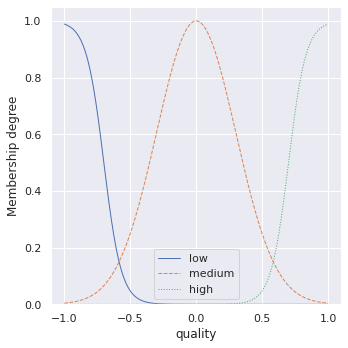

In [692]:
fs = FuzzySystem()
# fs.add_linguistic_variable(
#         "entropy", 
#         LinguisticVariable(define_gaussian_fuzzy_sets([-3.5, 1], n_splits=5), concept="entropy", universe_of_discourse=[-3.5, 1])
#     )
Q_1, Q_2, Q_3 = define_target_fuzzy_sets()
fs.add_linguistic_variable("quality", LinguisticVariable([Q_1, Q_2, Q_3], universe_of_discourse=[-1, 1]))
fs.produce_figure()

In [642]:
features_df.describe()

std         skew     kurtosis      entropy  pos_zc_int_mean  \
count  1049.000000  1049.000000  1049.000000  1049.000000      1049.000000   
mean     71.398569    -0.005707     2.155045    -0.966497         0.670913   
std      80.771093     0.887452     5.050068     0.531913         0.259973   
min       0.498119    -6.278308    -1.453442    -3.427461         0.171845   
25%      10.505289    -0.421837    -0.758180    -1.205916         0.472673   
50%      47.408679    -0.108233     0.222546    -0.785828         0.667757   
75%     100.776425     0.247694     2.904381    -0.557921         0.843835   
max     754.943358     4.913352    42.376044    -0.325507         2.190898   

       pos_zc_int_std  neg_zc_int_mean  neg_zc_int_std        label  
count     1049.000000      1049.000000     1049.000000  1049.000000  
mean         0.213404         0.670496        0.216351    -0.342231  
std          0.167205         0.259651        0.156003     0.865000  
min          0.007440         0.170886        0.010155    -1.000000  
25%          0.092818         0.465444        0.100608    -1.000000  
50%          0.200875         0.666049        0.198341    -1.000000  
75%          0.295669         0.838565        0.305581     1.000000  
max          2.684132         2.170234        1.801960     1.000000

In [624]:
# def create_fuzzy_system():
# # A simple fuzzy inference system for the tipping problem
# # Create a fuzzy system object
# FS = FuzzySystem()

# # Define fuzzy sets and linguistic variables
# # entropy_1 = FuzzySet(points= [[-3.5, 1], [-3, 0]           ], term="tiny", function=Gaussian_MF)
# # entropy_2 = FuzzySet(points= [[-3.5, 0], [-3, 1], [-2.5, 0]], term="very_small", function=Gaussian_MF)
# # entropy_3 = FuzzySet(points= [[-3, 0], [-2.5, 1], [-2, 0]], term="small", function=Gaussian_MF)
# # entropy_4 = FuzzySet(points= [[-2.5, 0], [-2, 1], [-1.5, 0]], term="medium", function=Gaussian_MF)
# # entropy_5 = FuzzySet(points= [[-2, 0], [-1.5, 1], [-1, 0]], term="big", function=Gaussian_MF)
# # entropy_6 = FuzzySet(points= [[-1.5, 0], [-1, 1], [-0.5, 0]], term="very_big", function=Gaussian_MF)
# # entropy_7 = FuzzySet(points= [[-1, 0], [-0.5, 1], [0, 0]], term="large", function=Gaussian_MF)
# # entropy_8 = FuzzySet(points= [[-0.5, 0], [0, 1]]           , term="very_large", function=Gaussian_MF)
# # FS.add_linguistic_variable(
# #     "entropy", 
# #     LinguisticVariable([entropy_1, entropy_2, entropy_3, entropy_4, entropy_5, entropy_6, entropy_7, entropy_8], concept="entropy")
# # )
# entropy_bounds = [-3.5, 0]
# FS.add_linguistic_variable(
#     "entropy", 
#     LinguisticVariable(define_gaussian_fuzzy_sets(entropy_bounds, n_splits=10), concept="entropy", universe_of_discourse=entropy_bounds)
# )

# # kurtosis_1 = FuzzySet(points= [[-5, 1],  [0,  0]],          term="very_tiny")
# # kurtosis_2 = FuzzySet(points= [[-5, 0],  [0,  1], [5,  0]], term="tiny")
# # kurtosis_3 = FuzzySet(points= [[0,  0],  [5,  1], [10, 0]], term="very_small")
# # kurtosis_4 = FuzzySet(points= [[5,  0],  [10, 1], [15, 0]], term="small")
# # kurtosis_5 = FuzzySet(points= [[10, 0],  [15, 1], [20, 0]], term="medium")
# # kurtosis_6 = FuzzySet(points= [[15, 0],  [20, 1], [25, 0]], term="big")
# # kurtosis_7 = FuzzySet(points= [[20, 0],  [25, 1], [30, 0]], term="very_big")
# # kurtosis_8 = FuzzySet(points= [[25, 0],  [30, 1], [35, 0]], term="large")
# # kurtosis_9 = FuzzySet(points= [[30, 0],  [35, 1], [40, 0]], term="very_large")
# # kurtosis_10 = FuzzySet(points=[[35, 0],  [40, 1]]         , term="enormous")
# # FS.add_linguistic_variable(
# #     "kurtosis", 
# #     LinguisticVariable([kurtosis_1, kurtosis_2, kurtosis_3, kurtosis_4, kurtosis_5, kurtosis_6, kurtosis_7, kurtosis_8, kurtosis_9, kurtosis_10], concept="kurtosis")
# # )
# kurtosis_bounds = [-5, 45]
# FS.add_linguistic_variable(
#     "kurtosis", 
#     LinguisticVariable(define_gaussian_fuzzy_sets(kurtosis_bounds, n_splits=10), concept="kurtosis", universe_of_discourse=kurtosis_bounds)
# )

# # std_1 = FuzzySet(points= [[0, 1], [1,   0]          ], term="small")
# # std_2 = FuzzySet(points= [[0, 0], [1,   1], [2, 0]], term="medium")
# # std_3 = FuzzySet(points= [[1, 0], [2, 1]]          , term="big")
# # std_1, std_2, std_3 = define_sigmoid_fuzzy_sets(0, 2, 1, 0.25)
# # FS.add_linguistic_variable(
# #     "std", 
# #     LinguisticVariable([std_1, std_2, std_3], concept="std", universe_of_discourse=[0, 2])
# # )
# std_bounds = [0, 10]
# FS.add_linguistic_variable(
#     "std", 
#     LinguisticVariable(define_gaussian_fuzzy_sets(std_bounds, n_splits=10), concept="std", universe_of_discourse=std_bounds)
# )


# # neg_zc_int_std_1 = FuzzySet(points= [[0,    1], [0.15, 0]],           term="very_small")
# # neg_zc_int_std_2 = FuzzySet(points= [[0,  0],   [0.15, 1], [0.3, 0]], term="small")
# # neg_zc_int_std_3 = FuzzySet(points= [[0.15, 0],  [0.3, 1], [0.45, 0]], term="medium")
# # neg_zc_int_std_4 = FuzzySet(points= [[0.3,  0], [0.45, 1]],           term="big")
# # FS.add_linguistic_variable(
# #     "neg_zc_int_std", 
# #     LinguisticVariable([neg_zc_int_std_1, neg_zc_int_std_2, neg_zc_int_std_3, neg_zc_int_std_4], concept="neg_zc_int_std")
# # )
# neg_zc_int_std_bounds = [0, 0.6]
# FS.add_linguistic_variable(
#     "neg_zc_int_std", 
#     LinguisticVariable(define_gaussian_fuzzy_sets(neg_zc_int_std_bounds, n_splits=10), concept="neg_zc_int_std", universe_of_discourse=neg_zc_int_std_bounds)
# )

# # skew_1 = FuzzySet(points= [[-5,    1], [-3, 0]],           term="very_small")
# # skew_2 = FuzzySet(points= [[-5,  0],   [-3, 1], [-1, 0]], term="small")
# # skew_3 = FuzzySet(points= [[-3, 0],  [-1, 1], [1, 0]], term="medium")
# # skew_4 = FuzzySet(points= [[-1,  0], [1, 1], [3, 0]], term="big")
# # skew_5 = FuzzySet(points= [[1,  0], [3, 1]],           term="very_big")
# # FS.add_linguistic_variable(
# #     "skew", 
# #     LinguisticVariable([skew_1, skew_2, skew_3, skew_4, skew_5], concept="skew")
# # )
# skew_bounds = [-5, 5]
# FS.add_linguistic_variable(
#     "skew", 
#     LinguisticVariable(define_gaussian_fuzzy_sets(skew_bounds, n_splits=10), concept="skew", universe_of_discourse=skew_bounds)
# )

# # pos_zc_int_mean_1 = FuzzySet(points= [[0,    1], [0.6, 0]],           term="small")
# # pos_zc_int_mean_2 = FuzzySet(points= [[0,  0],   [0.6, 1], [1.2, 0]], term="medium")
# # pos_zc_int_mean_3 = FuzzySet(points= [[0.6, 0],  [1.2, 1]], term="big")
# # pos_zc_int_mean_1, pos_zc_int_mean_2, pos_zc_int_mean_3 = define_sigmoid_fuzzy_sets(0, 1.2, 0.6, 0.15)
# # FS.add_linguistic_variable(
# #     "pos_zc_int_mean", 
# #     LinguisticVariable([pos_zc_int_mean_1, pos_zc_int_mean_2, pos_zc_int_mean_3], concept="pos_zc_int_mean", universe_of_discourse=[0, 1.2])
# # )
# pos_zc_int_mean_bounds = [0, 1.5]
# FS.add_linguistic_variable(
#     "pos_zc_int_mean", 
#     LinguisticVariable(define_gaussian_fuzzy_sets(pos_zc_int_mean_bounds, n_splits=10), concept="pos_zc_int_mean", universe_of_discourse=pos_zc_int_mean_bounds)
# )

# # Define output crisp values
# # FS.set_crisp_output_value("low",  -1)
# # FS.set_crisp_output_value("medium", 0)
# # FS.set_crisp_output_value("high",   1)


# # Define output fuzzy sets and linguistic variable
# # Q_1 = FuzzySet(points= [[-1,    1], [-0.5, 0]],           term="low")
# # Q_2 = FuzzySet(points= [[-0.5,  0], [0, 1], [0.5, 0]], term="medium")
# # Q_3 = FuzzySet(points= [[0.5,  0], [1, 1]],           term="high")
# Q_1, Q_2, Q_3 = define_sigmoid_fuzzy_sets(-1, 1, 0, 0)
# FS.add_linguistic_variable("quality", LinguisticVariable([Q_1, Q_2, Q_3], universe_of_discourse=[-1, 1]))


# # Define function for generous tip (food score + service score + 5%)
# # FS.set_output_function("generous", "Food+Service+5")

# FS.add_rules([
#     "IF (entropy IS 8) AND (kurtosis IS 1) THEN (quality IS high)",
#     # "IF (std IS small) THEN (quality IS low)",
#     "IF (skew IS 3) AND (NOT (pos_zc_int_mean IS small)) THEN (quality IS high)",
#     "IF (pos_zc_int_mean IS small) THEN (quality IS low)",
#     "IF (entropy IS 7) AND (kurtosis IS 1) THEN (quality IS medium)",
#     "IF (entropy IS 8) AND (neg_zc_int_std IS 1) THEN (quality IS high)",
#     "IF (entropy IS 7) AND (neg_zc_int_std IS 2) THEN (quality IS medium)"
# ])
# return FS

In [704]:
from simpful import *

def create_fuzzy_system():
    FS = FuzzySystem()

    entropy_bounds = [-3.5, 0]
    FS.add_linguistic_variable(
        "entropy", 
        LinguisticVariable(define_gaussian_fuzzy_sets(entropy_bounds, n_splits=10), concept="entropy", universe_of_discourse=entropy_bounds)
    )

    kurtosis_bounds = [-5, 45]
    FS.add_linguistic_variable(
        "kurtosis", 
        LinguisticVariable(define_gaussian_fuzzy_sets(kurtosis_bounds, n_splits=10), concept="kurtosis", universe_of_discourse=kurtosis_bounds)
    )

    std_bounds = [0, 10]
    FS.add_linguistic_variable(
        "std", 
        LinguisticVariable(define_gaussian_fuzzy_sets(std_bounds, n_splits=10), concept="std", universe_of_discourse=std_bounds)
    )

    neg_zc_int_std_bounds = [0, 0.6]
    FS.add_linguistic_variable(
        "neg_zc_int_std", 
        LinguisticVariable(define_gaussian_fuzzy_sets(neg_zc_int_std_bounds, n_splits=10), concept="neg_zc_int_std", universe_of_discourse=neg_zc_int_std_bounds)
    )

    skew_bounds = [-5, 5]
    FS.add_linguistic_variable(
        "skew", 
        LinguisticVariable(define_gaussian_fuzzy_sets(skew_bounds, n_splits=10), concept="skew", universe_of_discourse=skew_bounds)
    )

    pos_zc_int_mean_bounds = [0, 1.5]
    FS.add_linguistic_variable(
        "pos_zc_int_mean", 
        LinguisticVariable(define_gaussian_fuzzy_sets(pos_zc_int_mean_bounds, n_splits=10), concept="pos_zc_int_mean", universe_of_discourse=pos_zc_int_mean_bounds)
    )
    
    neg_zc_int_mean_bounds = [0, 1.5]
    FS.add_linguistic_variable(
        "neg_zc_int_mean", 
        LinguisticVariable(define_gaussian_fuzzy_sets(neg_zc_int_mean_bounds, n_splits=10), concept="neg_zc_int_mean", universe_of_discourse=neg_zc_int_mean_bounds)
    )


    Q_1, Q_2, Q_3 = define_target_fuzzy_sets()
    FS.add_linguistic_variable("quality", LinguisticVariable([Q_1, Q_2, Q_3], universe_of_discourse=[-1, 1]))

    FS.add_rules([
        "IF (entropy IS 10) AND (kurtosis IS 1) THEN (quality IS high)",
        "IF (kurtosis IS 5) OR (kurtosis IS 6) OR (kurtosis IS 7) OR (kurtosis IS 8) OR (kurtosis IS 8) OR (kurtosis IS 10) THEN (quality IS low)"
        # "IF (std IS 1) THEN (quality IS low)",
        "IF (skew IS 3) AND (NOT (pos_zc_int_mean IS 1)) THEN (quality IS high)",
        "IF (pos_zc_int_mean IS 1) THEN (quality IS low)",
        "IF (entropy IS 7) AND (kurtosis IS 1) THEN (quality IS medium)",
        "IF (entropy IS 8) AND (neg_zc_int_std IS 1) THEN (quality IS high)",
        "IF (entropy IS 7) AND (neg_zc_int_std IS 2) THEN (quality IS medium)",
        "IF (pos_zc_int_mean IS 1) AND (neg_zc_int_mean IS 1) THEN (quality IS low)",
        "IF (pos_zc_int_mean IS 1) AND (neg_zc_int_mean IS 1) THEN (quality IS low)",
        "IF (pos_zc_int_mean IS 2) AND (neg_zc_int_mean IS 2) THEN (quality IS low)",
        "IF (pos_zc_int_mean IS 3) AND (neg_zc_int_mean IS 3) THEN (quality IS low)",
        
    ])
    return FS

def predict(FS, features):
    feat_names = ["entropy", "kurtosis", "std", "neg_zc_int_std", "skew", "pos_zc_int_mean", "neg_zc_int_mean"]
    for feat_name in feat_names:
        FS.set_variable(feat_name, features[feat_name])
    return FS.Mamdani_inference(["quality"])['quality']


def predict_many(FS, features):
    preds = []
    for feats in features.iterrows():
        feats=feats[1]
        preds.append(predict(FS, feats))
    return preds


def rate_signal_fuzzy(signal, fuzzy_system, win_len=5, step=1, plot=True):
    signal_df = pd.DataFrame(data=signal, index=np.linspace(0, len(signal)/FS, len(signal), endpoint=False), columns=['data'])
    windows = get_windows(0, signal_df.index[-1], win_len, step)
    signal_slices = [signal_df.loc[start:end].values.flatten() for start, end in windows]
    signal_features = [{
        **get_quality_features(data),
        'start': start,
        'end': end
    } for data, (start, end) in zip(signal_slices, windows)]
    signal_features_df = pd.DataFrame(signal_features).drop(['start', 'end'], axis=1)#.dropna()
    # imputer = SimpleImputer()
    # features_array = imputer.fit_transform(signal_features_df.drop(['start', 'end'], axis=1).values)
    signal_slices_labels = predict_many(fuzzy_system, signal_features_df)
    signal_features_df['label'] = signal_slices_labels
    if plot:
        sig_range = signal.max() - signal.min()
        margin = 0.05 * sig_range
        lower_bound, upper_bound = signal.min() - margin, signal.max() + margin

        fig, ax = plt.subplots(figsize=(24, 5))
        ax.plot(signal_df.index, signal_df.data, color='black', lw=3)
        for label, (start, end) in zip(signal_slices_labels, windows):
            ax.fill_between([start, end], lower_bound, upper_bound, alpha=0.1, color=COLORMAP((label + 1) / 2)[:3])

        ax.set_ylim([lower_bound, upper_bound])
        ax.set_xlim([0, 100])
        
        return fig, signal_features_df
    return signal_features_df

  ____  __  _  _  ____  ____  _  _  __   
 / ___)(  )( \/ )(  _ \(  __)/ )( \(  ) v2.6.2 
 \___ \ )( / \/ \ ) __/ ) _) ) \/ (/ (_/\ 
 (____/(__)\_)(_/(__)  (__)  \____/\____/

 Created by Marco S. Nobile (m.s.nobile@tue.nl)
 and Simone Spolaor (simone.spolaor@unimib.it)



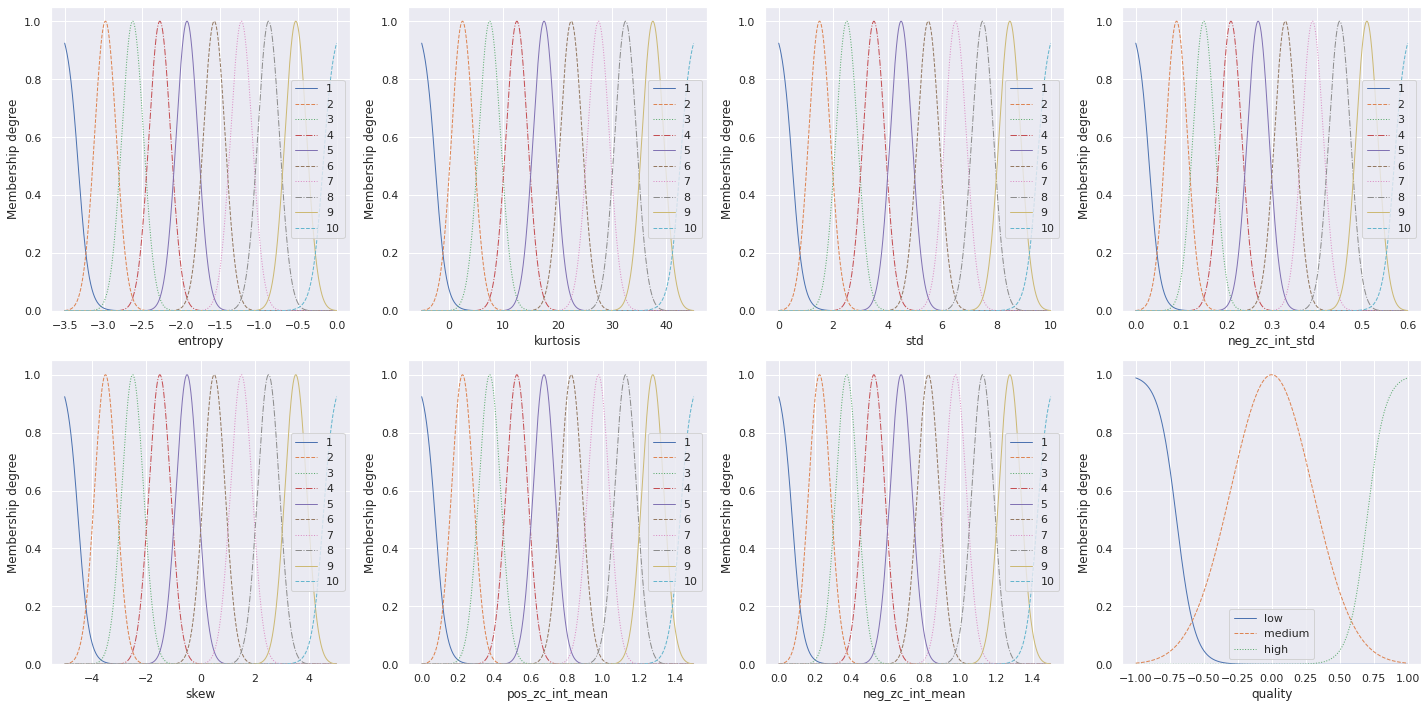

In [705]:
fuzzy_system = create_fuzzy_system()
# fuzzy_system.produce_figure()

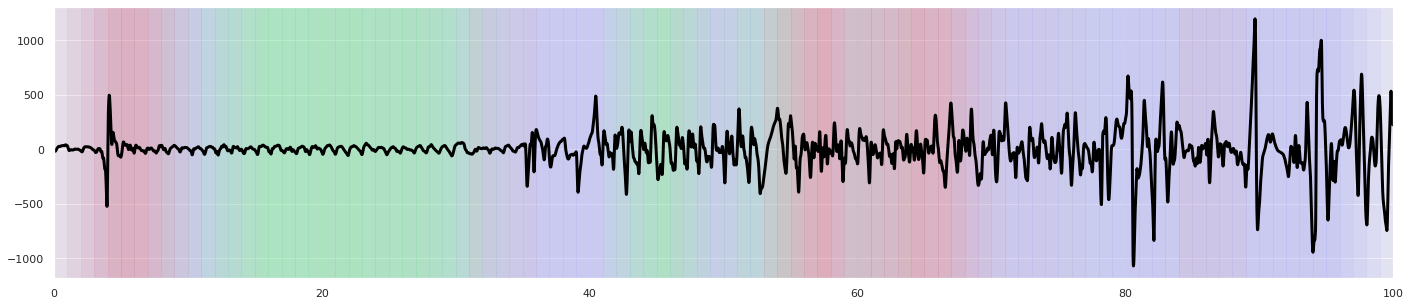

In [719]:
signal = example_signals[33]
fig, signal_features_df = rate_signal_fuzzy(signal, fuzzy_system)

In [708]:
signal_features_df

std      skew  kurtosis   entropy  pos_zc_int_mean  pos_zc_int_std  \
0   47.715349 -0.302972 -1.201809 -0.405548         0.790563        0.024015   
1   50.524340 -0.415082 -1.058325 -0.448919         0.797266        0.035234   
2   47.930680 -0.562185 -0.821802 -0.505073         0.797250        0.038094   
3   48.849577 -0.500913 -0.929693 -0.473932         0.788531        0.037754   
4   49.138214 -0.391500 -1.038954 -0.437464         0.795000        0.032866   
..        ...       ...       ...       ...              ...             ...   
91  70.512723  0.258928  0.128394 -0.735212         0.727656        0.281043   
92  79.339584 -0.087250  0.046561 -0.761378         0.733594        0.305645   
93  81.898005 -0.209090 -0.201686 -0.680826         0.782839        0.243669   
94  93.801065 -0.760674  1.006861 -0.863150         0.793469        0.199979   
95  88.616562 -0.932743  1.513820 -0.938421         0.736094        0.095892   

    neg_zc_int_mean  neg_zc_int_std         label  
0          0.787062        0.088369  7.029253e-01  
1          0.792094        0.090855  6.828170e-01  
2          0.799625        0.100191  6.562806e-01  
3          0.780937        0.090897  6.711013e-01  
4          0.810094        0.053881  6.881526e-01  
..              ...             ...           ...  
91         0.720547        0.219847 -1.755151e-17  
92         0.740729        0.223476 -4.113108e-17  
93         0.851187        0.133647  8.040858e-02  
94         0.789570        0.164487  3.861756e-18  
95         0.749594        0.111691  1.337741e-17  

[96 rows x 9 columns]

In [ ]:
figs = []

for signal in example_signals:
    fig, signal_features_df = rate_signal_fuzzy(signal, fuzzy_system)
    figs.append(fig)
    
save_figs_to_pdf(*figs, path='fuzzy_labeled_qualities.pdf')

/tmp/ipykernel_99605/2310597258.py:35: RuntimeWarning: Mean of empty slice.
  'pos_zc_int_mean': positive_zc_intervals.mean(),
/tmp/ipykernel_99605/2310597258.py:37: RuntimeWarning: Mean of empty slice.
  'neg_zc_int_mean': negative_zc_intervals.mean(),
/tmp/ipykernel_99605/3090252434.py:103: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(24, 5))
